In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans

from setuptools import setup
from yellowbrick.cluster import KElbowVisualizer

In [2]:
pd.options.display.max_columns = None
df = pd.read_csv('marketing_campaign.csv', sep='\t')

--------- DATA CLEANING -------------------

In [3]:
# encoding categorical values and casting dt_customer to datetime and extracting year from it
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format = '%d-%m-%Y')
df['Year_Enrollment'] = df['Dt_Customer'].dt.year
df = df.drop('Dt_Customer', axis=1)

pd.set_option('future.no_silent_downcasting', True) # enforces announced future update on downcasting(like seen below)
df["Education"] = df["Education"].replace({'Basic': 0, 'Graduation': 1, '2n Cycle': 2, 'Master': 2, 'PhD': 3})
df['Marital_Status'] = df["Marital_Status"].replace({'Single': 0, 'YOLO': 0, 'Absurd': 0, 'Alone': 0, 'Divorced': 0, 'Widow': 0, 'Married': 1, 'Together': 1})
df['Education'] = pd.to_numeric(df['Education'], errors='coerce').astype('int')
df['Marital_Status'] = pd.to_numeric(df['Marital_Status'], errors='coerce').astype('int')

In [4]:
# imputing missing income values with median income value.
imputer = SimpleImputer(strategy='median')
df['Income'] = imputer.fit_transform(df[['Income']])

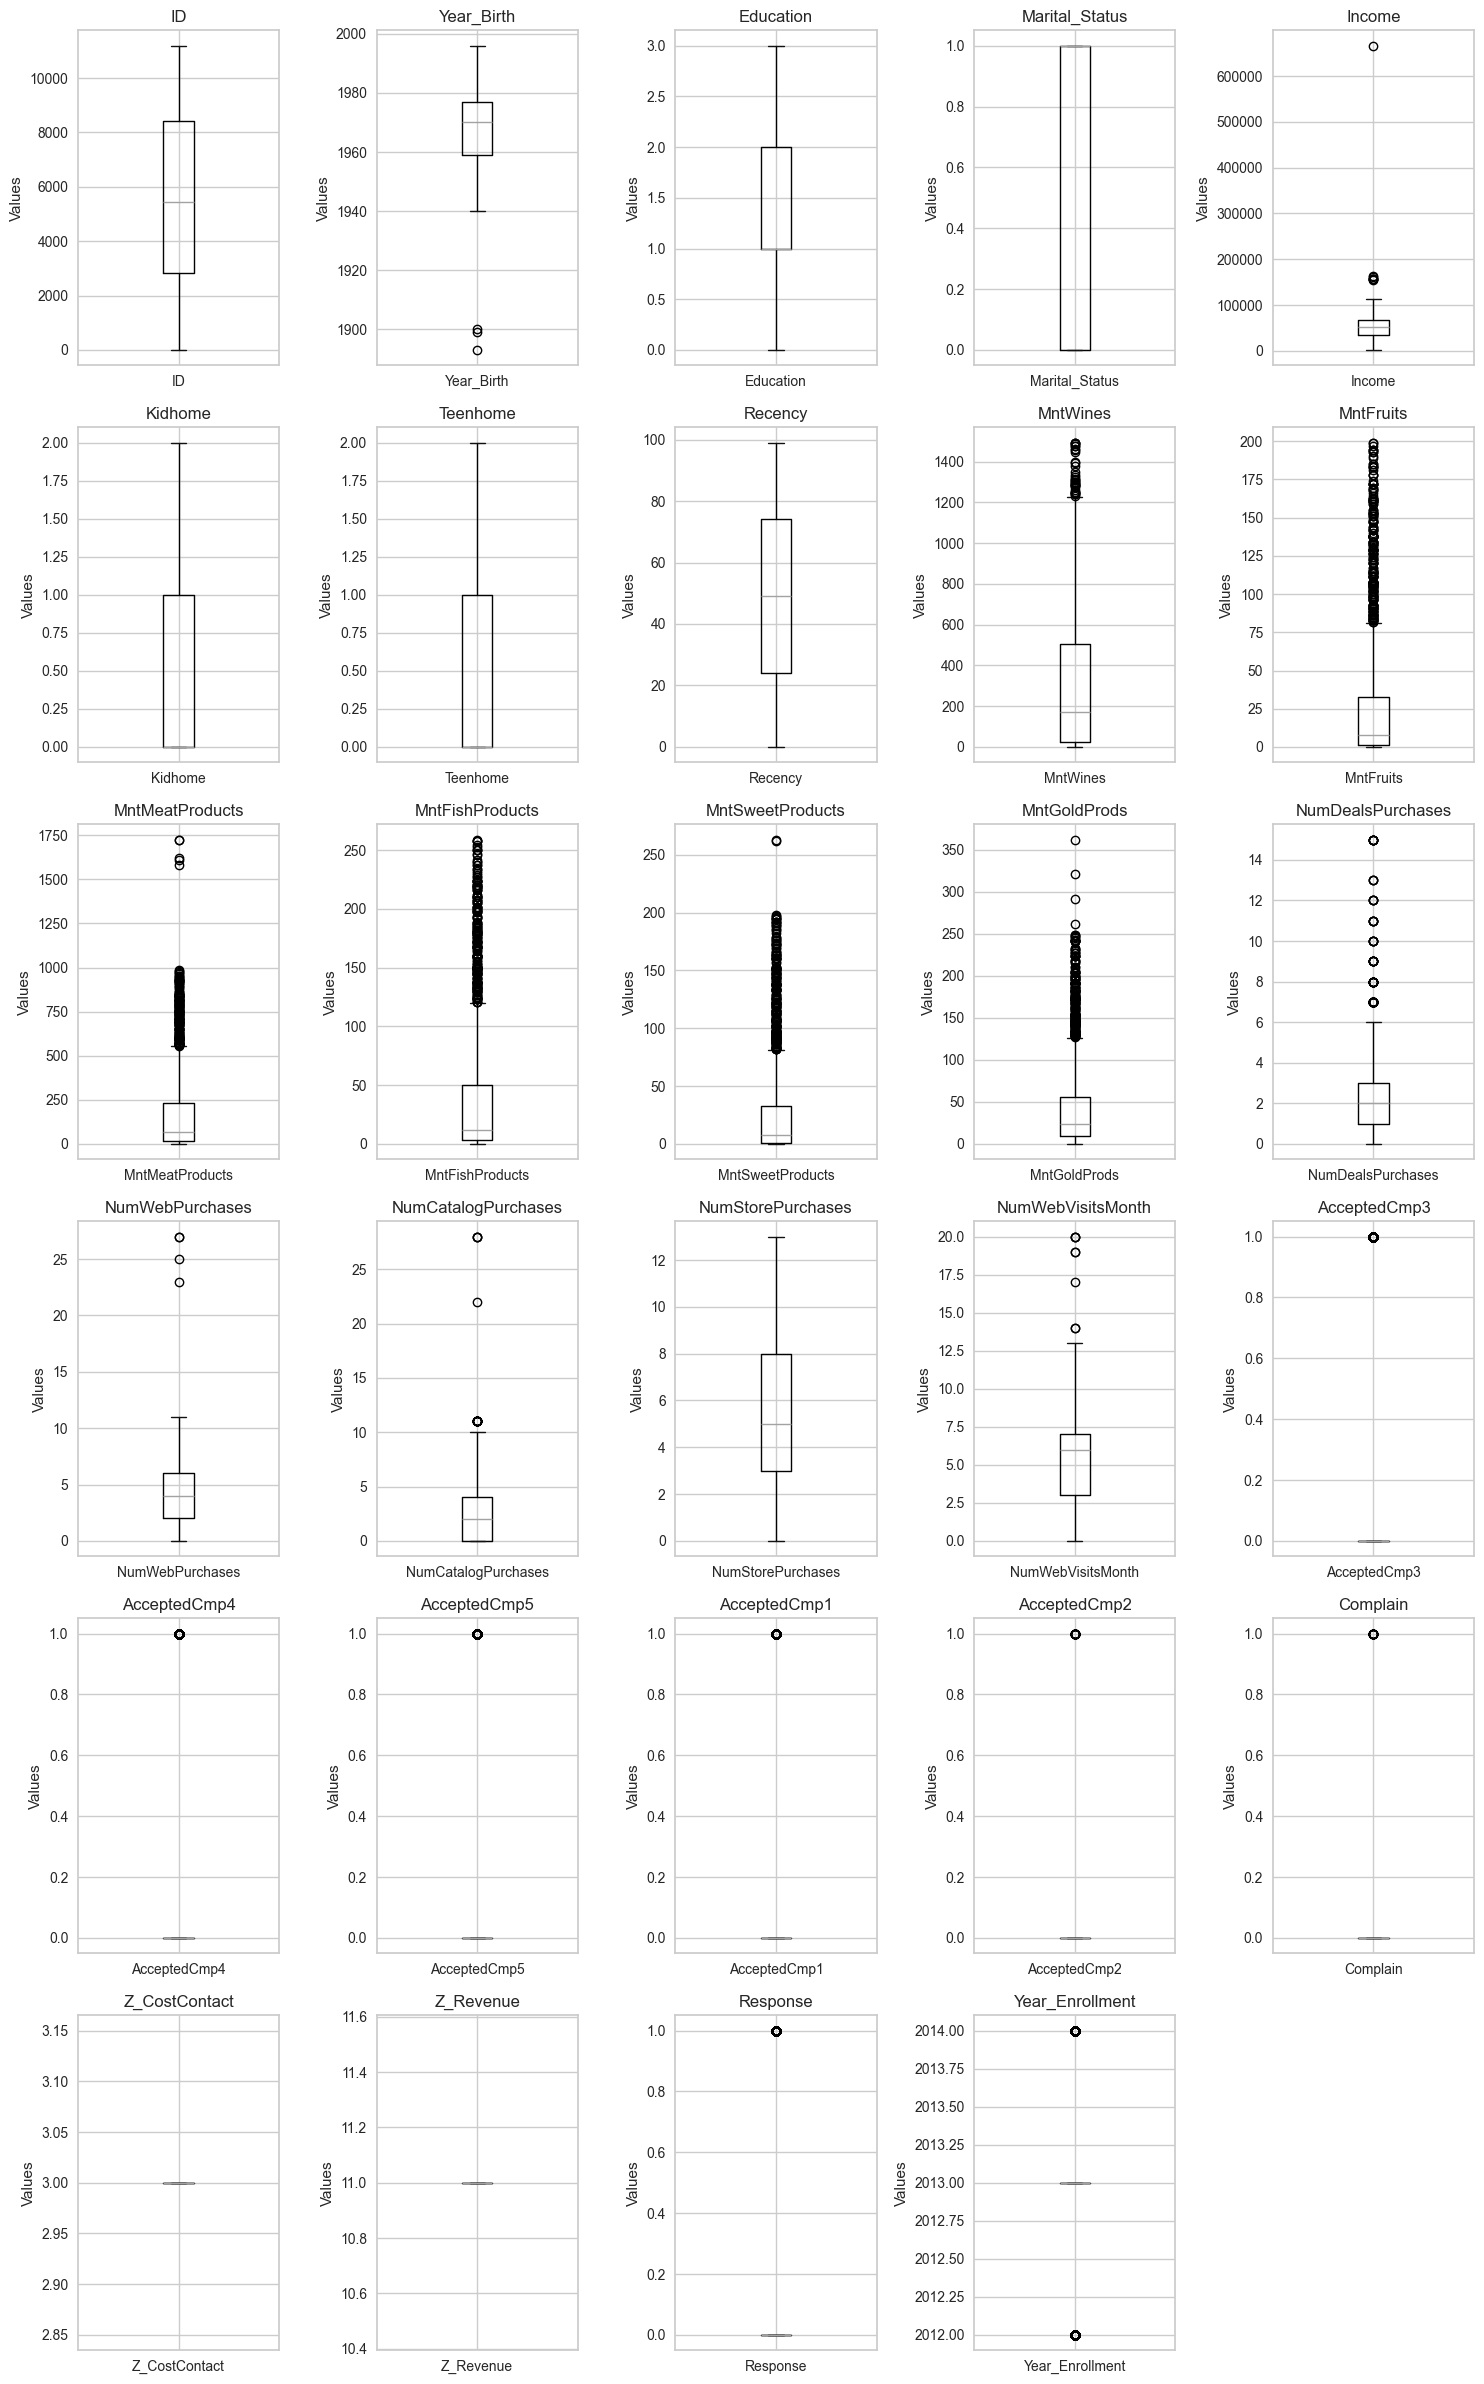

In [5]:
# looking at the data to see if removing outliers is needed
rows = int((27 + 4) / 5)
cols = min(5, 27)
plt.figure(figsize=(15, rows * 4))

numerical_columns = df.select_dtypes(include=[np.number])
for i, col in enumerate(df.columns):
    if col not in numerical_columns:
        continue
    plt.subplot(rows, cols, i + 1) 
    df.boxplot(column = col)
    plt.title(col)
    plt.ylabel('Values')

plt.tight_layout()
plt.show()

Looking at the boxplots, i decide to remove outliers in 'Year_Birth' and the one extreme outlier in 'income'. 
I guess the outliers in Year_Birth are supposed to be 19xx and not 18xx and the one outlier 66666.0 in 'income' is a mistake or false input that would distort the analysis even with scaling, since i want to use minmax scaling to retain readability especially in the 'Year_Birth' column.

In [6]:
# removing outliers in Year_Birth and income with IQR

def remove_iqr_outliers(df, column_name):
  Q1 = df[column_name].quantile(0.25)
  Q3 = df[column_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return df.loc[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]

df = remove_iqr_outliers(df.copy(), 'Income')
df = remove_iqr_outliers(df.copy(), 'Year_Birth')

# when looking at the boxplots again, we see that the desired outliers are removed

----------- FEATURE ENGINEERING ----------------

In [7]:
# combining all acceptedCmp columns into on, to show general acceptance
AcceptedCmp_columns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
df['AcceptedCmpSum'] = df[AcceptedCmp_columns].sum(axis=1)
df.drop(AcceptedCmp_columns, axis=1, inplace=True)

# combining Number of purchases 
Num_purchases_columns = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']
df['NumPurchasesSum'] = df[Num_purchases_columns].sum(axis=1)
df.drop(Num_purchases_columns, axis=1, inplace=True)

# combining amount of products ordered
Num_products_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df['MntProductsSum'] = df[Num_products_columns].sum(axis=1)
df.drop(Num_products_columns, axis=1, inplace=True)

#creating new column with ratio of average products per order
df['AvgProducts_per_Purchase'] = np.where(df['NumPurchasesSum'] == 0, 0, df['MntProductsSum'] / df['NumPurchasesSum'])
df = remove_iqr_outliers(df.copy(), 'AvgProducts_per_Purchase')

#combining teenhome and kidhome column
kids_columns = ['Kidhome', 'Teenhome']
df['Children'] = df[kids_columns].sum(axis=1)
df.drop(kids_columns, axis=1, inplace=True)

# creating new column with boolean value hasChild
df['hasChild'] = df['Children'].apply(lambda x: 1 if x > 0 else 0)

# dropping columns that always have the same value
df.drop(['Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)


-------------- NOMRALIZATION ---------------

In [8]:
# standardizing data by using minmax scaler
numerical_columns = df.select_dtypes(include=[np.number]).columns #identifies columns to be scaled
print(numerical_columns)
scaler = MinMaxScaler()
scaler.fit(df[numerical_columns])
df_scaled = df.copy()
df_scaled[numerical_columns] = scaler.transform(df[numerical_columns])

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Recency',
       'NumWebVisitsMonth', 'Complain', 'Response', 'Year_Enrollment',
       'AcceptedCmpSum', 'NumPurchasesSum', 'MntProductsSum',
       'AvgProducts_per_Purchase', 'Children', 'hasChild'],
      dtype='object')


------------ DIMENSION REDUCTION ----------------

In [9]:
# now that we have standardized values, we can use PCA for dimension reduction
pca = PCA(n_components = 0.80) #choosing as many components, so that the explained variance is nearest to 80%
pca.fit(df_scaled)
reduced = pca.transform(df_scaled.copy())
df_reduced = pd.DataFrame(reduced, columns=(['p_component1', 'p_component2', 'p_component3', 'p_component4', 'p_component5', 'p_component6', 'p_component7']))
print(reduced.size)

14910


------------ CLUSTERING ---------------------

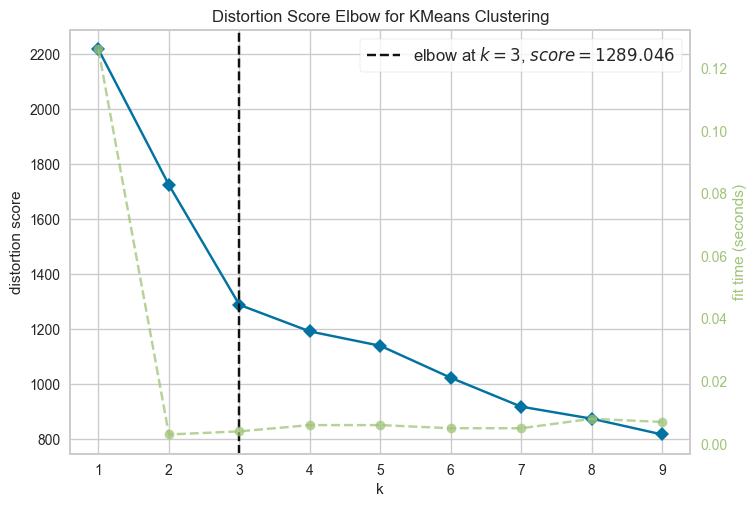

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [10]:
# using KElbowVisualizer to decide how many clusters we should form.

# instantiating the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(df_reduced)  
visualizer.show() 

The elbow plot shows that we should separate the data into 3 clusters.

In [11]:
# clustering using kmeans-clustering 
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_reduced)
cluster_labels = kmeans.labels_
df['cluster'] = cluster_labels

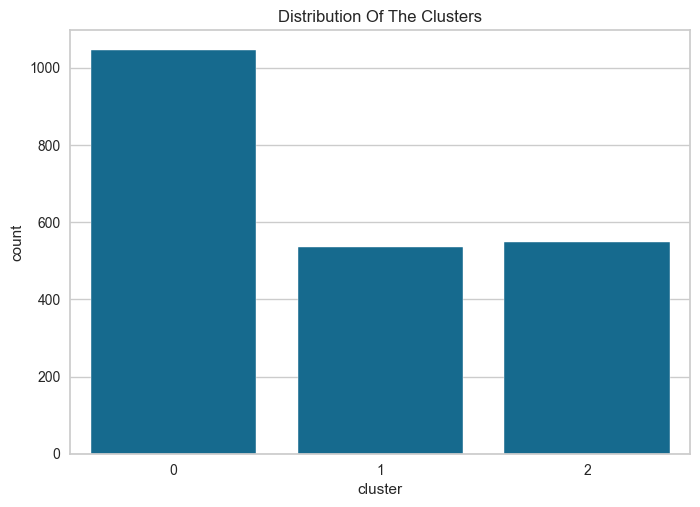

In [12]:
# visualizing sizes of clusters
pl = sns.countplot(x = df['cluster'])
pl.set_title("Distribution Of The Clusters")
plt.show()


------------- BASIC VISULAIZATION AND CONCLUSION ------------------------

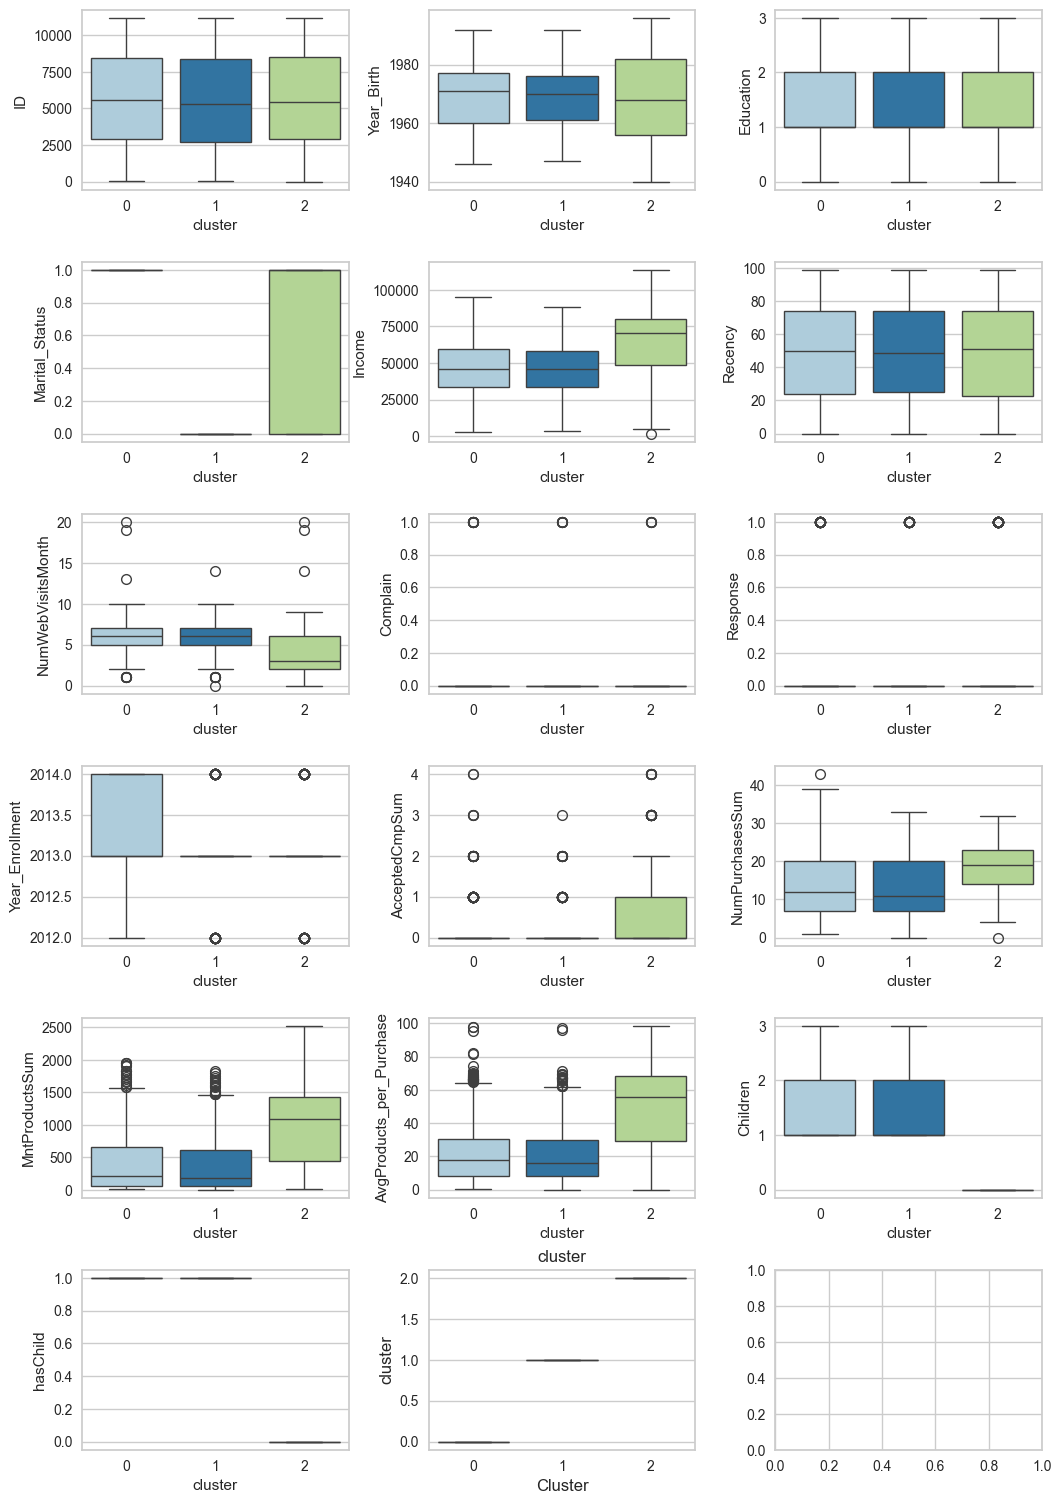

In [13]:
# visualizing clusters with boxplots
numerical_columns = df.columns
columns_per_row = 3
rows = (len(numerical_columns) + columns_per_row - 1) // columns_per_row
fig, axes = plt.subplots(nrows=rows, ncols=columns_per_row, figsize=(12, rows * 3)) 
axes = axes.ravel()

for num, col in enumerate(numerical_columns):
  row, col_index = divmod(num, columns_per_row)

  sns.boxplot(
      data=df,
      y=col,
      x="cluster",
      palette="Paired",
      hue = "cluster",
      legend = False,
      ax=axes[row * columns_per_row + col_index]  
  )

axes[row * columns_per_row + col_index].set_xlabel('Cluster', fontsize=12)
axes[row * columns_per_row + col_index].set_ylabel(f'{col}', fontsize=12)
axes[row * columns_per_row + col_index].set_title(col, fontsize=12) 

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)

plt.show()

---------------------- CONCLUSION ----------------------

Cluster0 Properties: <br>
- is in a relationship <br>
- slightly below average income <br>
- less likely to accept campaign <br>
- has 1 or more children <br>
- below average purchase volume and number of purchases

Cluster1 Properties: <br>
- is in a relationship <br>
- slightly below average income <br>
- less likely to accept campaign <br>
- has 1 or more children <br>
- below average purchase volume and number of purchases

Cluster2 Properties: <br>
- might be in a relationship <br>
- above average income <br>
- more likely to accept campaign <br>
- has no children <br>
- above average purchase volume and number of purchases